**Инструкция по выполнению проекта:**

* 1. Подготовьте данные
* 1.1. Откройте файлы и изучите их.
* 1.2. Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.
* 1.3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?
* 1.4. Проведите предобработку данных.
* 2. Проанализируйте данные
* 2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.
* 2.2.  Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.
* 2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 
* 3. Постройте модель
* 3.1. Напишите функцию для вычисления итоговой sMAPE.
* 3.2. Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

**Описание данных**
**Технологический процесс**
* Rougher feed — исходное сырье
* Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant  
* Xanthate **— ксантогенат (промотер, или активатор флотации);
* Sulphate — сульфат (на данном производстве сульфид натрия);
* Depressant — депрессант (силикат натрия).
* Rougher process (англ. «грубый процесс») — флотация
* Rougher tails — отвальные хвосты
* Float banks — флотационная установка
* Cleaner process — очистка
* Rougher Au — черновой концентрат золота
* Final Au — финальный концентрат золота

**Параметры этапов**
* air amount — объём воздуха
* fluid levels — уровень жидкости
* feed size — размер гранул сырья
* feed rate — скорость подачи

**Наименование признаков**

Наименование признаков должно быть такое:
*[этап].[тип_параметра].[название_параметра]*
Пример: **rougher.input.feed_ag**

**Возможные значения для блока [этап]:**
* rougher — флотация
* primary_cleaner — первичная очистка
* secondary_cleaner — вторичная очистка
* final — финальные характеристики

**Возможные значения для блока [тип_параметра]:**
* input — параметры сырья
* output — параметры продукта
* state — параметры, характеризующие текущее состояние этапа
* calculation — расчётные характеристики

In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor

## Подготовка данных

In [2]:
try:
    data_train = pd.read_csv('D:\gold_recovery_train_new.csv')
    data_test = pd.read_csv('D:\gold_recovery_test_new.csv')
    data_full = pd.read_csv('D:\gold_recovery_full_new.csv')
except:
    data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
    data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [3]:
print(data_train.head(), data_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


**На этом этапе выполнено:**
* Импортирование датасетов
* Первичный обзор данных
* Оценка количества пропусков

*выведен только Train датасет для более простого обзора (мной проверены все)*

### Расчет MAE для recovery

In [4]:
def recovery_calc(C, F, T):
    recovery = (C*(F-T))/(F*(C-T))
    return recovery * 100
    

rougher_recovery = recovery_calc(
                                data_train['rougher.output.concentrate_au'],
                                data_train['rougher.input.feed_au'],
                                data_train['rougher.output.tail_au']
)

rougher_au_mae = mean_absolute_error(data_train['rougher.output.recovery'], rougher_recovery)

rougher_au_mae

9.73512347450521e-15

**На данном этапе:**
* Создана функция для расчета recovery
* Расчитана величина расхождения между данными в датасете и recovery по формуле

**Вывод:**

После ручной проверки мы видим, что ошибки в столбце recovery нет.

### Признаки, недоступные в тестовой выборке

In [5]:
data_train_columns = list(data_train.columns)
data_test_columns = list(data_test.columns)
data_diff = []

for i in data_train_columns:
    if i not in data_test_columns:
        data_diff.append(i)
        
print(data_diff)

['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au', 'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb', 'final.output.tail_sol', 'final.output.tail_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au', 'rougher.output.recovery', 'rougher.output.tail_ag', 'rougher.output.tail_pb', 'rougher.output.tail_sol', 'rougher.output.tai

При сравнении названий столбцов мы видим, что в тестовую выборку **не попадают** значения **парметров продукта, расчетные характеристики, а также целевой признак.**

### Предобработка данных

In [6]:
data_train = data_train.ffill()
data_test = data_test.ffill()
data_full = data_full.ffill()

print(data_full.duplicated().sum())

0


In [7]:
data_train = data_train.loc[data_train['rougher.output.concentrate_au'] > 2]
data_train = data_train.loc[data_train['primary_cleaner.output.concentrate_au'] > 2]
data_train = data_train.loc[data_train['final.output.concentrate_au'] > 2]

data_train = data_train.loc[data_train['primary_cleaner.output.concentrate_ag'] > 2]
data_train = data_train.loc[data_train['final.output.concentrate_ag'] > 2]

data_train = data_train.loc[data_train['primary_cleaner.output.concentrate_pb'] > 2]
data_train = data_train.loc[data_train['final.output.concentrate_pb'] > 2]

data_train = data_train.loc[data_train['primary_cleaner.output.concentrate_sol'] > 2]
data_train = data_train.loc[data_train['final.output.concentrate_sol'] > 2]

**На этом этапе выполнено:**
* Пропуски во всех датасетах заполнены методом ffil
* Данные проверены на наличие дубликатов
* Из обучающей выборки удалены аномальные данные

## Анализ данных

### Золото

C:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel

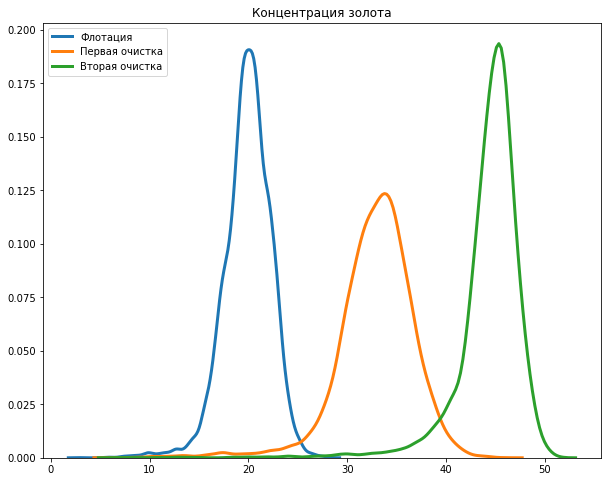

In [8]:
plt.figure(figsize=(10,8))
sns.distplot(data_train['rougher.output.concentrate_au'], hist=False, kde_kws = {'linewidth': 3}, label='Флотация')
sns.distplot(data_train['primary_cleaner.output.concentrate_au'], hist=False, kde_kws = {'linewidth': 3}, label='Первая очистка')
sns.distplot(data_train['final.output.concentrate_au'], hist=False, kde_kws = {'linewidth': 3}, label='Вторая очистка')
plt.ylabel('')
plt.xlabel('')
plt.title('Концентрация золота')
plt.legend()
plt.show()

На данном графике мы можем увидеть, как меняется концетрация золота в продукте на каждом этапе. Так, мы можем сказать, что с каждым этапом концетрация золота увеличивается.

### Серебро

C:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel

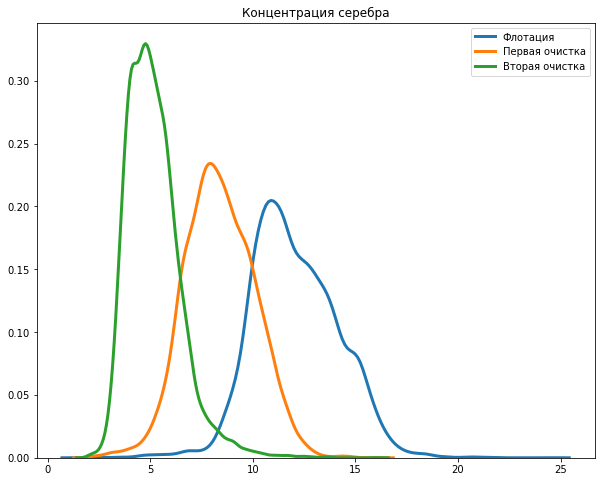

In [9]:
plt.figure(figsize=(10,8))
sns.distplot(data_train['rougher.output.concentrate_ag'], hist=False, kde_kws = {'linewidth': 3}, label='Флотация')
sns.distplot(data_train['primary_cleaner.output.concentrate_ag'], hist=False, kde_kws = {'linewidth': 3}, label='Первая очистка')
sns.distplot(data_train['final.output.concentrate_ag'], hist=False, kde_kws = {'linewidth': 3}, label='Вторая очистка')
plt.ylabel('')
plt.xlabel('')
plt.title('Концентрация серебра')
plt.legend()
plt.show()

На данном графике представлено изменение концетрации серебра. Концетрация серебра в продукте уменьшается, однако ширина разброса концетраций в продукте становится ниже.

### Свинец

C:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel

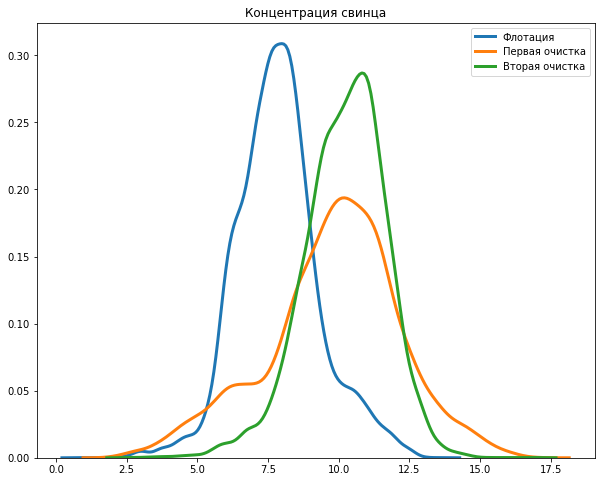

In [10]:
plt.figure(figsize=(10,8))
sns.distplot(data_train['rougher.output.concentrate_pb'], hist=False, kde_kws = {'linewidth': 3}, label='Флотация')
sns.distplot(data_train['primary_cleaner.output.concentrate_pb'], hist=False, kde_kws = {'linewidth': 3}, label='Первая очистка')
sns.distplot(data_train['final.output.concentrate_pb'], hist=False, kde_kws = {'linewidth': 3}, label='Вторая очистка')
plt.ylabel('')
plt.xlabel('')
plt.title('Концентрация свинца')
plt.legend()
plt.show()

Концетрация свинца, однако, не сильно меняется. После первой и второй очистки она почти не меняется.

### Размер гранул

C:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


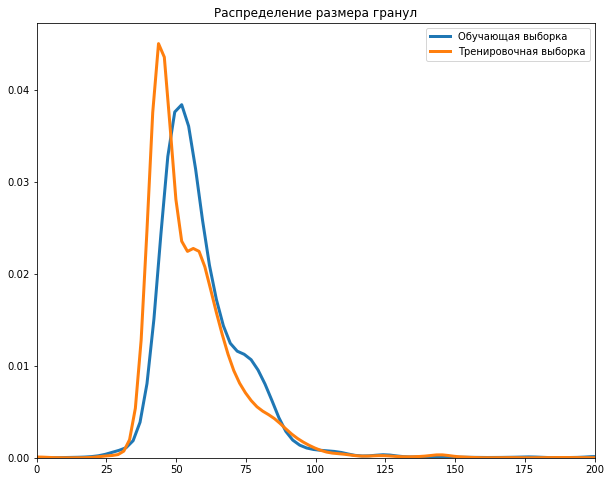

In [11]:
plt.figure(figsize=(10,8))
sns.distplot(data_train['rougher.input.feed_size'], hist=False, kde_kws = {'linewidth': 3}, label='Обучающая выборка')
sns.distplot(data_test['rougher.input.feed_size'], hist=False, kde_kws = {'linewidth': 3}, label='Тренировочная выборка')
plt.xlim(0, 200)
plt.ylabel('')
plt.xlabel('')
plt.title('Распределение размера гранул')
plt.legend()
plt.show()

На данном графике мы видим распределение размера гранул на тестовой и обучающей выборках. Разница есть, но не существенная.

### Общая концетрация металлов

C:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel

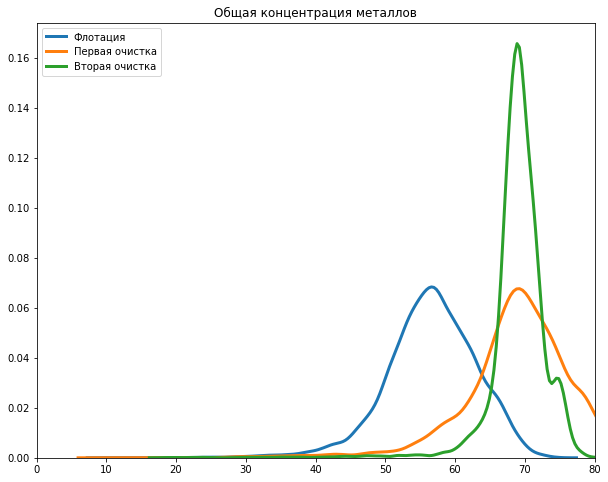

In [12]:
first_sum = data_train['rougher.input.feed_au'] + data_train['rougher.input.feed_ag'] \
+ data_train['rougher.input.feed_pb'] + data_train['rougher.input.feed_sol']

second_sum = data_train['rougher.output.concentrate_au'] + data_train['rougher.output.concentrate_ag'] \
+ data_train['rougher.output.concentrate_pb'] + data_train['rougher.output.concentrate_sol']

third_sum = data_train['final.output.concentrate_au'] + data_train['final.output.concentrate_ag'] \
+ data_train['final.output.concentrate_pb'] + data_train['final.output.concentrate_sol']

plt.figure(figsize=(10,8))
sns.distplot(first_sum, hist=False, kde_kws = {'linewidth': 3}, label='Флотация')
sns.distplot(second_sum, hist=False, kde_kws = {'linewidth': 3}, label='Первая очистка')
sns.distplot(third_sum, hist=False, kde_kws = {'linewidth': 3}, label='Вторая очистка')
plt.xlim(0, 80)
plt.ylabel('')
plt.xlabel('')
plt.title('Общая концентрация металлов')
plt.legend()
plt.show()

Да данном графике представлена общая концетрация металлов на разных стадиях. Мы видим, что после флотации концетрация растет. Также мы видим, что после финальной очистки разброс концетраций становится значительно ниже, чем после предыдущих двух этапов.

## Выбор модели

### Функция для расчета sMAPE

In [13]:
def smape(target , pred):
    return 1/ len(target) * np.sum(2 * np.abs(pred-target) / (np.abs(target) + np.abs(pred))*100)

smape_scorer = make_scorer(smape, greater_is_better=False)

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> `smape` расчитана верно.</font>

<font color='blue'><b>Комментарий ревьюера 2: </b></font> ✔️ <br>
<font color='green'>Верно, что не забываешь указать greater_is_better=False, Это пригодится для SearchCV. SMAPE — ошибка, её минимизируем.</font>

### Подготовим данные для обучения моделей

#### Флотация

In [14]:
rougher_data = data_train.loc[:, 'rougher.calculation.sulfate_to_au_concentrate':'rougher.state.floatbank10_f_level']

rougher_data = rougher_data.drop(
                                    ['rougher.calculation.sulfate_to_au_concentrate', 
                                    'rougher.calculation.floatbank10_sulfate_to_au_feed',
                                    'rougher.calculation.floatbank11_sulfate_to_au_feed', 
                                    'rougher.calculation.au_pb_ratio',
                                    'rougher.output.tail_ag',
                                    'rougher.output.tail_pb',
                                    'rougher.output.tail_sol',
                                    'rougher.output.tail_au',
                                    'rougher.output.concentrate_ag',
                                    'rougher.output.concentrate_pb', 
                                    'rougher.output.concentrate_sol',
                                    'rougher.output.concentrate_au'], axis=1
)



rougher_feat = rougher_data.drop(['rougher.output.recovery'], axis=1)
rougher_target = rougher_data['rougher.output.recovery']

In [15]:
rougher_test_feat = data_test[rougher_feat.columns]
rougher_test_target = data_full[data_full['date'].isin(data_test['date'])] 
rougher_test_target = rougher_test_target['rougher.output.recovery']

**На данном этапе было выполнено:**
* Подготовлены выборки для обучения и тестирования для предказаний после флотации

In [16]:
LR = LinearRegression()

LR_score = cross_val_score(LR, rougher_feat, rougher_target, cv=5, scoring=smape_scorer)

print(LR_score.mean())

-6.792787241659826


In [17]:
DT = DecisionTreeRegressor(random_state=666, max_depth=20)

DT_score = cross_val_score(DT, rougher_feat, rougher_target, cv=5, scoring=smape_scorer)

print(DT_score.mean())

-8.3100246886141


In [18]:
FT = RandomForestRegressor(random_state=666, max_depth=17, n_estimators=12)

FT_score = cross_val_score(FT, rougher_feat, rougher_target, cv=5, scoring=smape_scorer)

print(FT_score.mean())

-6.481089362859019


**На этом этапе выполнено:**
* Созданы модели для расчета предзказаний на этапе флотации
* Модели проверены с помощью техники кросс-валидация для выбора наиболее подходящей

#### Финальный recovery

In [19]:
final_data = data_train.drop(data_diff, axis=1)
final_data = final_data.drop(
                            ['date',
                            'rougher.input.feed_ag', 
                            'rougher.input.feed_pb',                       
                            'rougher.input.feed_rate',                    
                            'rougher.input.feed_size',                     
                            'rougher.input.feed_sol',                      
                            'rougher.input.feed_au',                      
                            'rougher.input.floatbank10_sulfate',           
                            'rougher.input.floatbank10_xanthate',         
                            'rougher.input.floatbank11_sulfate',           
                            'rougher.input.floatbank11_xanthate',          
                            'rougher.state.floatbank10_a_air',             
                            'rougher.state.floatbank10_a_level',           
                            'rougher.state.floatbank10_b_air',             
                            'rougher.state.floatbank10_b_level',           
                            'rougher.state.floatbank10_c_air',             
                            'rougher.state.floatbank10_c_level',           
                            'rougher.state.floatbank10_d_air',             
                            'rougher.state.floatbank10_d_level',           
                            'rougher.state.floatbank10_e_air',             
                            'rougher.state.floatbank10_e_level',           
                            'rougher.state.floatbank10_f_air',            
                            'rougher.state.floatbank10_f_level'], axis=1)

final_data = final_data.join(data_train['final.output.recovery'])


final_feat = final_data.drop(['final.output.recovery'], axis=1)
final_target = final_data['final.output.recovery']

In [20]:
final_test_feat = data_test[final_feat.columns]
final_test_target = data_full[data_full['date'].isin(data_test['date'])] 
final_test_target = final_test_target['final.output.recovery']

**На данном этапе было выполнено:**
* Подготовлены выборки для обучения и тестирования для предсказаний после финальной очистки

In [21]:
LRF = LinearRegression()

LRF_score = cross_val_score(LRF, final_feat, final_target, cv=5, scoring=smape_scorer)

print(LRF_score.mean())

-9.534474490955736


In [22]:
DTF = DecisionTreeRegressor(random_state=666, max_depth=20)

DTF_score = cross_val_score(DTF, final_feat, final_target, cv=5, scoring=smape_scorer)

print(DTF_score.mean())

-18.331616762652818


In [23]:
FTF = RandomForestRegressor(random_state=666, max_depth=17, n_estimators=12)

FTF_score = cross_val_score(FTF, final_feat, final_target, cv=5, scoring=smape_scorer)

print(FTF_score.mean())

-12.912752826320084


**На этом этапе выполнено:**
* Созданы модели для расчета предзказаний на финальном этапе
* Модели проверены с помощью техники кросс-валидация для выбора наиболее подходящей

**Вывод:**

Наиболее подходящей под нашу задачу оказались модели *леса деревьев и линейной регрессии*.

### Итоговые модели

#### Подберем лучшие параметры с помощью GridSearch

In [24]:
parametrs = {
    'max_depth': range(1, 40, 1),
    'n_estimators': range(1, 5, 1)
}

grid = GridSearchCV(FT, param_grid=parametrs, cv=5, scoring=smape_scorer, n_jobs=-1)

FT_best = grid.fit(rougher_feat, rougher_target)
FT_proba = FT_best.predict(rougher_test_feat)
rougher_smape = smape(rougher_test_target, FT_proba)

print('sMAPE флотации:', rougher_smape)

sMAPE флотации: 8.422023221887535


In [25]:
dummy = DummyRegressor(strategy="mean")

dummy.fit(rougher_feat, rougher_target)
dummy_proba = dummy.predict(rougher_test_feat)
dummy_smape = smape(rougher_test_target, dummy_proba)

print('sMAPE dummy флотации:', dummy_smape)

sMAPE dummy флотации: 8.910428537608551


In [26]:
LRF_best = LRF.fit(final_feat, final_target)
LRF_proba = LRF_best.predict(final_test_feat)
final_smape = smape(final_test_target, LRF_proba)

print('sMAPE финальный:', final_smape)

sMAPE финальный: 9.632832359113555


In [27]:
dummy_f = DummyRegressor(strategy="mean")

dummy_f.fit(final_feat, final_target)
dummy_f_proba = dummy_f.predict(final_test_feat)
dummy_f_smape = smape(final_test_target, dummy_f_proba)

print('sMAPE dummy финальный:', dummy_f_smape)

sMAPE dummy финальный: 9.970153610781711


**На этом этапе выполнено:**
* Для обеих моделей подобраны наилучшие параметры с помощью техники GridSearch
* С помощью созданной ранее формулы расчитано sMAPE для этапов флотации и финальной очистки

### Итоговый sMAPE

In [28]:
def smape_grand(rougher, final):
    return (0.25 * rougher) + (0.75 * final)

In [29]:
grand_smape = smape_grand(rougher_smape, final_smape)

print(grand_smape)

9.33013007480705


**Вывод:**
Наилучшей моделью для расчета предсказаний recovery этапов флотации и финальной очистки стали **лес деревьев и линейная регрессия**.
Однако, несмотря на лучшие показатели, предсказания могут оказаться *не точными*, т.к. разница со средними значениями, предсказанными **dummy** моделью очень маленькая.
Стоит отметить, что все модели показали слабые результаты и не подходят для реальной работы с подобными данными. Возможно, дело именно в самих данных или в их некорректных замерах. 

**Итоговый sMAPE на предсказанных данных составил 9.33.**